In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import random


# sys.path.append("..")
# from functions import build_vocab, encode_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [75]:
import re
from collections import Counter


def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[.,:]', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '[name]', text)
    return text

def tokenize_text(text):
    return clean_text(text).split()

nameslist = pd.read_csv('../../data/names.csv')
nameslist = nameslist['name'].tolist()

def build_vocab(texts):
    tokenized_texts = [tokenize_text(text) for text in texts]
    all_words = [word for text in tokenized_texts for word in text if word.isalnum()]
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    
    top_words = sorted_words[:1000]
    
    word_to_idx = {word: idx+1 for idx, word in enumerate(top_words)}
    word_to_idx['<PAD>'] = 0
    word_to_idx['<UNK>'] = len(word_to_idx)
    word_to_idx['[name]'] = len(word_to_idx)
    return word_to_idx, tokenized_texts

def is_illegal_word(word):
    return any(char.isalnum() == False for char in word) or word not in word_to_idx

def encode_sequences(tokenized_texts, word_to_idx):
    sequences = []
    for tokens in tokenized_texts:
        for startPoint in range(len(tokens)): # on average the sequences might be too small for good training
            seq = []
            for i in range(startPoint, len(tokens)):
                target = tokens[i]  
                if is_illegal_word(target) or is_illegal_word(target):
                    break
                if len(seq)>0: 
                    encoded_seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in seq]
                    encoded_target = word_to_idx.get(target, word_to_idx['<UNK>'])
                    sequences.append((encoded_seq, encoded_target))
                seq.append(target)
    return sequences

folder_path = '../../data/x'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:1]  

dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

texts = df['text'].tolist()

print(f"Loaded {len(texts)} text samples from CSV.")

word_to_idx, tokenized_texts = build_vocab(texts)
sequences = encode_sequences(tokenized_texts, word_to_idx)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of sequences: {len(sequences)}")

Loaded 10000 text samples from CSV.
Vocabulary size: 1003
Number of sequences: 239108


In [76]:
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target), len(sequence)


class NextWordLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_prob=0.3, repetition_penalty=1.0):
        super(NextWordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.repetition_penalty = repetition_penalty
    
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :]) 
        out = self.fc(lstm_out)
        
        if self.repetition_penalty != 1.0:
            for i in range(out.size(0)):
                for token in x[i]:
                    out[i, token] /= self.repetition_penalty
        
        return out
    
def collate_fn(batch):
    sequences, targets, lengths = zip(*batch)
    lengths = torch.tensor(lengths)
    
    sequences_padded = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0)
    targets = torch.tensor(targets)
    
    return sequences_padded, targets, lengths


# if use test_train split function the val will be contaminated
train_sequences, val_sequences = sequences[:int(len(sequences)*0.8)], sequences[int(len(sequences)*0.8):]
random.shuffle(train_sequences)
random.shuffle(val_sequences)

train_dataset = TextDataset(train_sequences)
val_dataset = TextDataset(val_sequences)

batch_size = 32
train_dataset = TextDataset(train_sequences)
val_dataset = TextDataset(val_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [77]:
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

for i in range(100):
    sequence, target, le = val_dataset[i]
    sequence_words = [idx_to_word[idx.item()] for idx in sequence]
    target_word = idx_to_word[target.item()]
    print(f"Sequence {i + 1}: {' '.join(sequence_words)} -> {target_word}")

Sequence 1: have gone wrong -> on
Sequence 2: a -> spring
Sequence 3: understand -> why
Sequence 4: to watch -> the
Sequence 5: tomorrow -> so
Sequence 6: another late -> night
Sequence 7: out of the -> house
Sequence 8: too i -> cant
Sequence 9: anyone -> came
Sequence 10: forward -> to
Sequence 11: from -> our
Sequence 12: now im sad that i apparently -> did
Sequence 13: its not really a spring break its just a 4 day -> weekend
Sequence 14: to do with -> the
Sequence 15: i want a new -> job
Sequence 16: since i -> have
Sequence 17: make -> money
Sequence 18: wish i -> was
Sequence 19: too much to watch it -> happen
Sequence 20: asked my friend if we were in -> a
Sequence 21: of -> the
Sequence 22: the hang of this but none -> of
Sequence 23: that -> was
Sequence 24: i work for a -> lot
Sequence 25: though -> if
Sequence 26: in bed -> with
Sequence 27: and miss a -> nice
Sequence 28: had -> a
Sequence 29: wish i -> could
Sequence 30: fix it -> right
Sequence 31: better get it done and

In [78]:
def validate_model(model, val_loader, criterion):
    model.eval()  
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  
        for sequences, targets, length in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()  

        for batch_idx, (sequences, targets, length) in enumerate(train_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
            best_model = model  
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model = best_model
    return train_losses, val_losses, val_accuracies


model = NextWordLSTM(vocab_size=len(word_to_idx), embed_size=128, hidden_size=256, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Starting training...


C:\Users\Theodor\AppData\Local\Temp\ipykernel_19764\1409044125.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0)


Epoch [1/3] completed, Average Train Loss: 4.9404, Validation Loss: 4.6689, Validation Accuracy: 0.1499
Epoch [2/3] completed, Average Train Loss: 4.0601, Validation Loss: 4.6659, Validation Accuracy: 0.1594
Epoch [3/3] completed, Average Train Loss: 3.5620, Validation Loss: 4.7891, Validation Accuracy: 0.1562


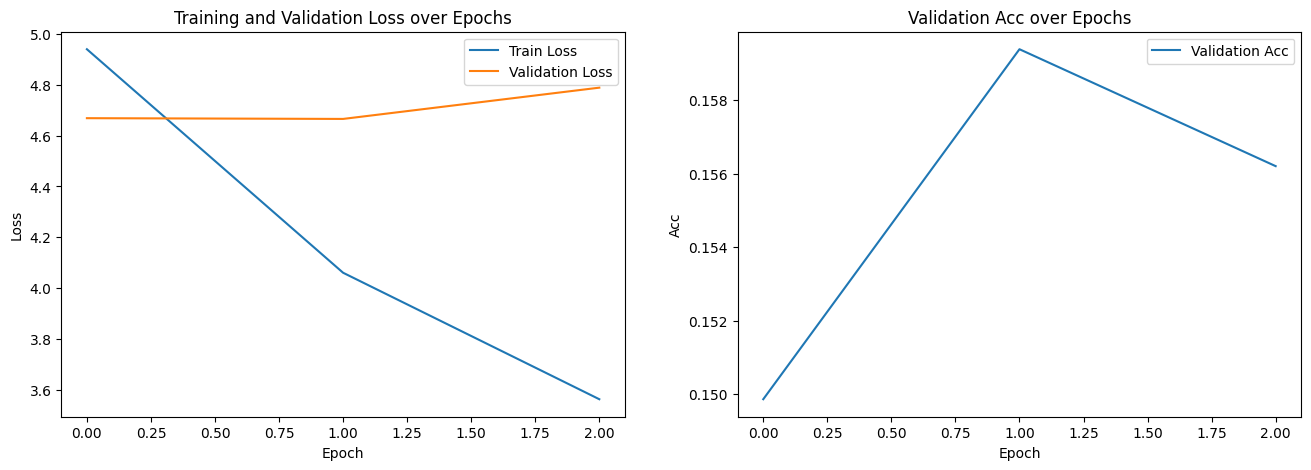

In [79]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].legend()

axs[1].plot(val_accuracies, label="Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_title("Validation Acc over Epochs")
axs[1].legend()

plt.show()

In [80]:
import json

vocab_save_path = 'vocabulary.json'
with open(vocab_save_path, 'w') as f:
    json.dump(word_to_idx, f)
print(f"Vocabulary saved to {vocab_save_path}")

model_save_path = 'model.pth'
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Vocabulary saved to vocabulary.json
Model saved to model.pth


In [81]:
def predict_next_word(model, sequence, idx_to_word):
    model.eval()
    sequence = torch.tensor(sequence).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(sequence)
        predicted_idx = torch.argmax(output, dim=1).item()
    return idx_to_word[predicted_idx]


idx_to_word = {idx: word for word, idx in word_to_idx.items()}

indata = [word_to_idx[words] for words in "what did".split()]
print(predict_next_word(model, indata, idx_to_word))

i


In [82]:
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

for i in range(100):
    sequence, target, length = val_dataset[i+1000]
    sequence_words = [idx_to_word[idx.item()] for idx in sequence]
    target_word = idx_to_word[target.item()]
    predicted_word = predict_next_word(model, sequence, idx_to_word)
    print(f"Sequence {i + 1}: {' '.join(sequence_words)} -> {target_word} (Predicted: {predicted_word})")

Sequence 1: is sick bring -> him (Predicted: on)
Sequence 2: today the -> dr (Predicted: one)
Sequence 3: missed -> her (Predicted: my)
Sequence 4: and man i -> can (Predicted: have)
Sequence 5: heading -> out (Predicted: to)
Sequence 6: have a -> laptop (Predicted: new)
Sequence 7: of his all cuz -> of (Predicted: of)
Sequence 8: of looking -> for (Predicted: a)
Sequence 9: trip -> to (Predicted: to)
Sequence 10: and new -> girl (Predicted: one)
Sequence 11: are at -> so (Predicted: work)
Sequence 12: is supposed -> to (Predicted: to)
Sequence 13: in my world for some reason i guess i -> have (Predicted: will)
Sequence 14: start thing is the second half -> of (Predicted: in)
Sequence 15: get up -> 2 (Predicted: early)
Sequence 16: but my parents -> would (Predicted: is)
Sequence 17: still got a -> year (Predicted: new)
Sequence 18: my friends -> are (Predicted: is)
Sequence 19: got a little -> too (Predicted: bit)
Sequence 20: am bored at home with no camera or friends -> online (Pred

C:\Users\Theodor\AppData\Local\Temp\ipykernel_19764\3129473792.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).unsqueeze(0).to(device)


Sequence 88: i -> wanna (Predicted: have)
Sequence 89: car -> broke (Predicted: and)
Sequence 90: rather than -> in (Predicted: a)
Sequence 91: eyes i -> think (Predicted: have)
Sequence 92: doing -> my (Predicted: my)
Sequence 93: sad im -> missing (Predicted: not)
Sequence 94: feel -> really (Predicted: like)
Sequence 95: very hungry but it is -> after (Predicted: not)
Sequence 96: not managed -> to (Predicted: to)
Sequence 97: i -> see (Predicted: have)
Sequence 98: want to -> buy (Predicted: go)
Sequence 99: caught the -> cold (Predicted: same)
Sequence 100: at the -> same (Predicted: end)
